# Run meta-analyses on 21 pain studies
Collection of NIDM-Results packs downloaded from Neurovault collection [1425](https://www.neurovault.org/collections/1425/), uploaded by Dr. Camille Maumet.

In [1]:
%matplotlib inline
import json
import numpy as np
from glob import glob
from os.path import basename, join, dirname, isfile
import urllib.request
import os

import pandas as pd
import nibabel as nib
from scipy.stats import t
from nilearn.masking import apply_mask
from nilearn.plotting import plot_stat_map

import nimare
from nimare.meta.ibma import (stouffers, fishers, weighted_stouffers,
                              rfx_glm, ffx_glm)

/home/james/.conda/envs/nimare_dev/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/duecredit-0.6.4-py3.7.egg/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/duecredit-0.6.4-py3.7.egg/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Iterator
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/nipype-1.1.7-py3.7.egg/nipype/interfaces/base/traits_extension.py:28: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.a

In [2]:
url = "https://raw.githubusercontent.com/tsalo/NiMARE/coco2019/download_test_data.py"
u = urllib.request.urlopen(url)
data = u.read()
u.close()

# write python to file
with open("download_test_data.py", "wb") as f:
    f.write(data)

# download the requisite data
from download_test_data import download_dataset
download_dataset()

In [3]:
dset_file = join(dirname(nimare.__file__), 'tests', 'data', 'nidm_pain_dset.json')
with open(dset_file, 'r') as fo:
    dset_dict = json.load(fo)
db = nimare.dataset.Database(dset_file)
dset = db.get_dataset()

mask_img = dset.mask

logp_thresh = -np.log(.05)

## Define functions for querying set of NIDM-Results packs

In [4]:
def _get_file(cdict, t):
    """Return the file associated with a given data type within a
    folder if it exists. Otherwise, returns an empty list.
    """
    temp = ''
    if t == 'con':
        temp = cdict['images'].get('con')
    elif t == 'se':
        temp = cdict['images'].get('se')
    elif t == 't':
        temp = cdict['images'].get('t')
    elif t == 'z':
        temp = cdict['images'].get('z')
    elif t == 'n':
        temp = cdict.get('sample_sizes', [])
        if temp:
            temp = np.mean(temp)
    else:
        raise Exception('Input type "{0}" not recognized.'.format(t))

    return temp


def get_files(ddict, types):
    """Returns a list of files associated with a given data type 
    from a set of subfolders within a directory. Allows for
    multiple data types and only returns a set of files from folders
    with all of the requested types.
    """
    all_files = []
    for study in ddict.keys():
        files = []
        cdict = ddict[study]['contrasts']['1']
        for t in types:
            temp = _get_file(cdict, t)
            if temp:
                files.append(temp)
            
        if len(files) == len(types):
            all_files.append(files)
    all_files = list(map(list, zip(*all_files)))
    return all_files

## Get z-maps

In [5]:
files = get_files(dset_dict, ['z'])
z_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in files[0]]
z_data = apply_mask(z_imgs, mask_img)
print('{0} studies found.'.format(z_data.shape[0]))

11 studies found.


## Fisher's

/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


CPU times: user 2.09 s, sys: 50.3 ms, total: 2.14 s
Wall time: 1.15 s


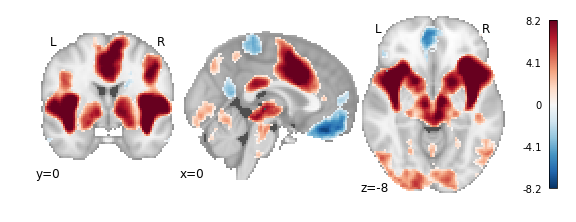

In [6]:
%%time
result = fishers(z_data, mask_img)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

## Stouffer's

### Fixed-effects inference

CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 693 ms


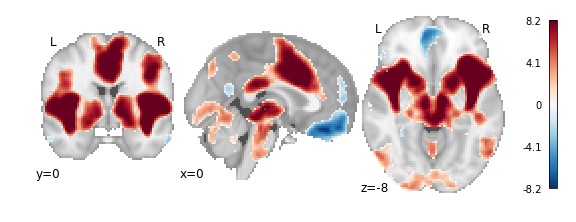

In [7]:
%%time
result = stouffers(z_data, mask_img, inference='ffx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Random-effects inference with theoretical null distribution

/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 1.56 s, sys: 0 ns, total: 1.56 s
Wall time: 797 ms


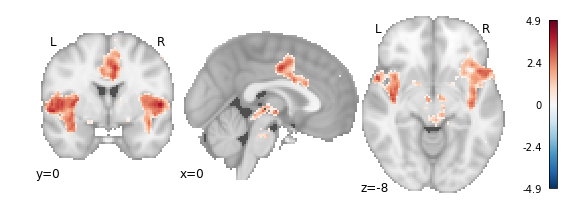

In [8]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

### Random-effects inference with empirical null distribution

CPU times: user 4min 37s, sys: 351 ms, total: 4min 38s
Wall time: 2min 21s


/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/nilearn-0.5.0-py3.7.egg/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


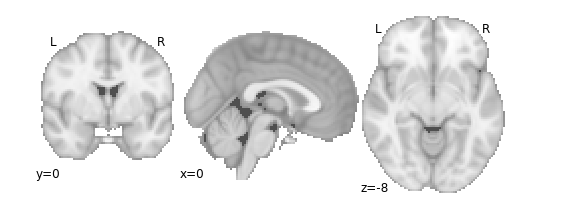

In [9]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='empirical', n_iters=1000)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## Get z-maps + sample sizes

In [10]:
z_files, ns = get_files(dset_dict, ['z', 'n'])
z_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in z_files]
z_data = apply_mask(z_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(z_data.shape[0]))

11 studies found.


## Weighted Stouffer's

CPU times: user 1.37 s, sys: 7.97 ms, total: 1.38 s
Wall time: 695 ms


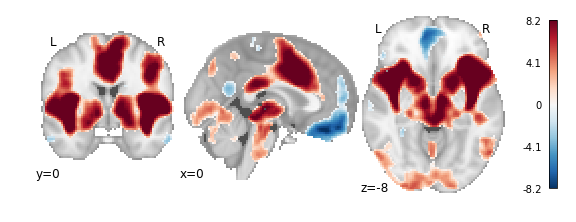

In [11]:
%%time
result = weighted_stouffers(z_data, sample_sizes, mask_img)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## Get contrast maps + contrast standard error maps + sample sizes

In [12]:
con_files, se_files, ns = get_files(dset_dict, ['con', 'se', 'n'])
con_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in con_files]
se_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in se_files]
con_data = apply_mask(con_imgs, mask_img)
se_data = apply_mask(se_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(con_data.shape[0]))

/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


21 studies found.


## FFX GLM

190114-16:55:11,278 nipype.interface INFO:
	 stdout 2019-01-14T16:55:11.278010:Log directory is: stats
190114-16:55:11,279 nipype.interface INFO:
	 stdout 2019-01-14T16:55:11.279881:Setting up:
190114-16:55:12,585 nipype.interface INFO:
	 stdout 2019-01-14T16:55:12.585393:ntptsing=21.000000 
190114-16:55:12,586 nipype.interface INFO:
	 stdout 2019-01-14T16:55:12.585393:
190114-16:55:12,587 nipype.interface INFO:
	 stdout 2019-01-14T16:55:12.585393:evs_group=1.000000 
190114-16:55:12,588 nipype.interface INFO:
	 stdout 2019-01-14T16:55:12.585393:
190114-16:55:12,589 nipype.interface INFO:
	 stdout 2019-01-14T16:55:12.589319:No f contrasts
190114-16:55:12,707 nipype.interface INFO:
	 stdout 2019-01-14T16:55:12.707300:
190114-16:55:12,708 nipype.interface INFO:
	 stdout 2019-01-14T16:55:12.707300:WARNING: The passed in varcope file, /media/Data/Documents/devel/NiMARE/examples/mfx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be exclu

/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


CPU times: user 6.1 s, sys: 373 ms, total: 6.47 s
Wall time: 12.5 s


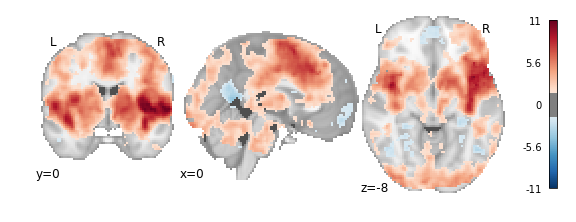

In [13]:
%%time
result = ffx_glm(con_data, se_data, sample_sizes, mask_img)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8], 
              threshold=1.65, draw_cross=False, cmap='RdBu_r')

## Get contrast maps

In [14]:
con_files = get_files(dset_dict, ['con'])
con_files = con_files[0]
con_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in con_files]
con_data = apply_mask(con_imgs, mask_img)
print('{0} studies found.'.format(con_data.shape[0]))

/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


21 studies found.


## RFX GLM

### Theoretical null distribution

/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 1.81 s, sys: 7.8 ms, total: 1.82 s
Wall time: 931 ms


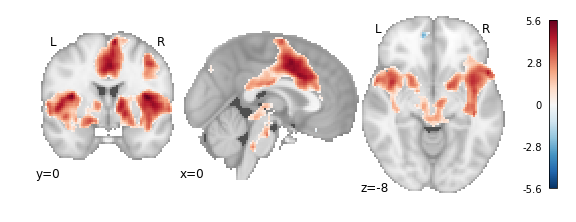

In [15]:
%%time
result = rfx_glm(con_data, mask_img, null='theoretical', n_iters=None)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Empirical null distribution

CPU times: user 5min 46s, sys: 563 ms, total: 5min 47s
Wall time: 2min 55s


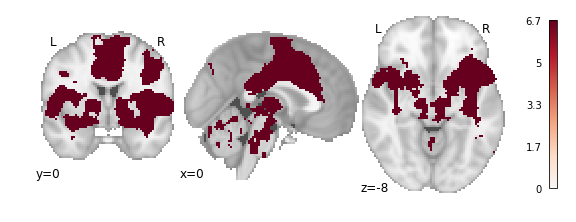

In [16]:
%%time
result = rfx_glm(con_data, mask_img, null='empirical', n_iters=1000)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## MKDA

### Density analysis

CPU times: user 2.73 s, sys: 305 ms, total: 3.04 s
Wall time: 9.48 s


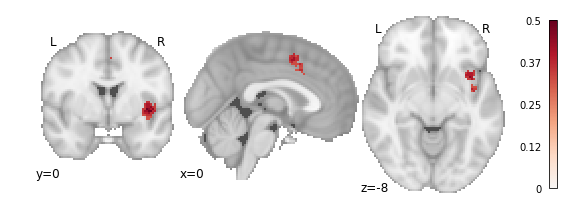

In [17]:
%%time
mkda = nimare.meta.cbma.MKDADensity(dset, kernel__r=10)
mkda.fit(n_iters=10, ids=dset.ids)
plot_stat_map(mkda.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FDR correction

/media/Data/Documents/devel/NiMARE/nimare/meta/cbma/mkda.py:218: RuntimeWarning: divide by zero encountered in true_divide
  pFgA = pAgF * pF / pA
/media/Data/Documents/devel/NiMARE/nimare/meta/cbma/mkda.py:218: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


CPU times: user 5.65 s, sys: 84.1 ms, total: 5.73 s
Wall time: 4.58 s


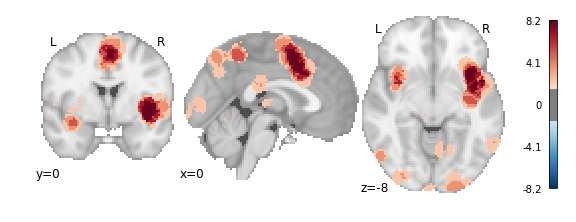

In [18]:
%%time
mkda2 = nimare.meta.cbma.MKDAChi2(dset, kernel__r=10)
mkda2.fit(corr='FDR', ids=dset.ids, ids2=dset.ids)
plot_stat_map(mkda2.results.images['consistency_z'], threshold=1.65, cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FWE correction

Now running iteration 0


/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


CPU times: user 8.92 s, sys: 180 ms, total: 9.1 s
Wall time: 10.5 s


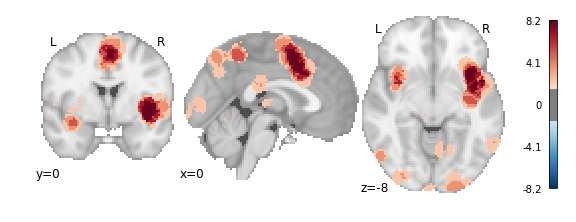

In [19]:
%%time
mkda3 = nimare.meta.cbma.MKDAChi2(dset, kernel__r=10)
mkda3.fit(corr='FWE', n_iters=10, ids=dset.ids, ids2=dset.ids)
plot_stat_map(mkda3.results.images['consistency_z'], threshold=1.65, cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

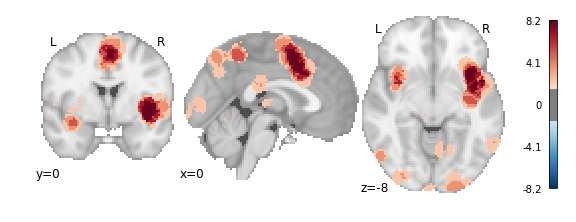

In [20]:
plot_stat_map(mkda3.results.images['consistency_z'], threshold=1.65, cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## KDA

CPU times: user 1.41 s, sys: 104 ms, total: 1.52 s
Wall time: 8.27 s


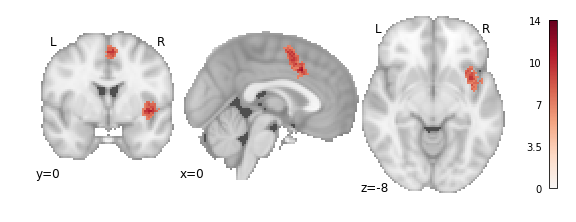

In [21]:
%%time
kda = nimare.meta.cbma.KDA(dset, kernel__r=10)
kda.fit(n_iters=10, ids=dset.ids)
plot_stat_map(kda.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## ALE

CPU times: user 5.29 s, sys: 377 ms, total: 5.67 s
Wall time: 11.8 s


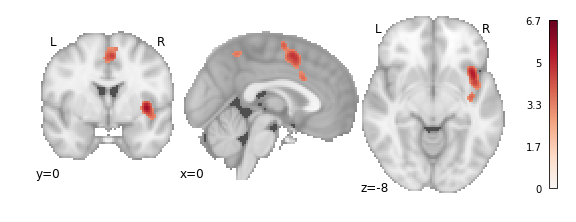

In [22]:
%%time
ale = nimare.meta.cbma.ALE(dset, ids=dset.ids)
ale.fit(n_iters=10, ids=dset.ids)
plot_stat_map(ale.results.images['cfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## SCALE

CPU times: user 35.1 s, sys: 5.39 s, total: 40.5 s
Wall time: 45.1 s


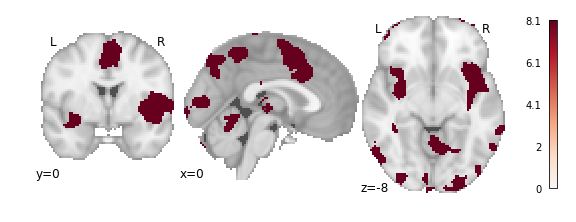

In [23]:
%%time
ijk = np.vstack(np.where(dset.mask.get_data())).T
scale = nimare.meta.cbma.SCALE(dset, ijk=ijk)
scale.fit(n_iters=10, ids=dset.ids)
plot_stat_map(scale.results.images['vthresh'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')